# Genomic Foundation Models for Understanding Regulatory Sequences

## Path setup and imports

This version of the notebook was used with Google Colab:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [164]:
%pip install transformers datasets tokenizers

In [ ]:
import pandas as pd
import random
from datasets import Dataset
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Change device to GPU
device = torch.device('cuda')

In [ ]:
# Set random seeds for reproducibility
from transformers import set_seed
set_seed(11)
np.random.seed(11)

## Preparing data

Due to lack of access to HPC and powerful computational resources, I use the significantly smaller version of the DHS dataset that is provided by Meuleman et al. here: https://www.meuleman.org/research/synthseqs/.

In [ ]:
# Load dataset
train_data = pd.read_csv('https://www.meuleman.org/train_all_classifier_light.csv.gz', delimiter='\t', usecols=['raw_sequence', 'component'])
val_data = pd.read_csv('https://www.meuleman.org/validation_all_classifier_light.csv.gz', delimiter='\t', usecols=['raw_sequence', 'component'])

selected_labels = [i for i in range (1, 17)]

# Filter the dataframe
train_data = train_data[train_data['component'].isin(selected_labels)]
val_data = val_data[val_data['component'].isin(selected_labels)]

# Create a Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

In [ ]:
# # Reload
# from transformers import AutoModelForSequenceClassification
# from transformers import AutoTokenizer

# num_labels = len(train_data['component'].unique())  # Number of unique labels in component column
# model = AutoModelForSequenceClassification.from_pretrained("results/checkpoint-600", num_labels=num_labels, ignore_mismatched_sizes=True)
# tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-50m-multi-species")
# model = model.to(device)

## Download and import NT model and tokenizer from Hugging Face

The `AutoModelForSequenceClassification` interface replaces the default classification head with an appropriate one for fine-tuning on a new task, according to the `num_labels` argument. Here we have 16 classes instead of the default 2. It is also possible to create a fully custom classification layer and use it for fine-tuning for more specialized tasks if needed. That requires using the native PyTorch interface for defining new modules.

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

model_name = "InstaDeepAI/nucleotide-transformer-v2-50m-multi-species"
tokenizer = AutoTokenizer.from_pretrained(model_name)

num_labels = len(train_data['component'].unique())  # Number of unique labels in component column
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, trust_remote_code=True)
model = model.to(device)

Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-50m-multi-species were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-50m-multi-species and are newly initialized: ['classifier.dense.bias', 'c

Here, both the train and validation sets are tokenized for use in the training later:

In [ ]:
# Convert 'component' column to numerical labels
label_map = {label: idx for idx, label in enumerate(train_data['component'].unique())}
train_data['labels'] = train_data['component'].map(label_map)
val_data['labels'] = val_data['component'].map(label_map)

# Convert the DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

# Define a function to preprocess the data
def preprocess_function(examples):
    inputs = tokenizer(examples['raw_sequence'], truncation=True, max_length=200)
    inputs['labels'] = examples['labels']
    return inputs

# Apply the preprocessing function to the datasets
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_val_dataset = val_dataset.map(preprocess_function, batched=True)

# Remove the unnecessary columns after tokenization to avoid issues during training
tokenized_train_dataset = tokenized_train_dataset.remove_columns(['raw_sequence', 'component'])
tokenized_val_dataset = tokenized_val_dataset.remove_columns(['raw_sequence', 'component'])

Map:   0%|          | 0/160000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Now define an appropriate evaluation metric to be used on the validation set to monitor training progress. Most relevant papers use the Matthews correlation coefficient (MCC), which is a robust metric for multiclass classifications and is known as a balanced measure which can be used even if the classes are of very different sizes.

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, matthews_corrcoef

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Compute metrics
    f1 = f1_score(labels, predictions, average='macro')
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    mcc = matthews_corrcoef(labels, predictions)

    return {
        'accuracy': accuracy,
        'macro_f1': f1,
        'precision': precision,
        'recall': recall,
        'mcc': mcc
    }

Here we set up the configuration of the training loop. Once again, this is a Hugging Face interface and is different from native PyTorch training loop. A PyTorch loop can also be implemented relatively easily if needed, in order to have more fine-grained control over the details of the training process.

In [152]:
# Set up the Trainer
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./checkpoints",
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,    # Number of steps between checkpoints if save_strategy="steps"
    logging_steps= 100,
    num_train_epochs=1,
    learning_rate=1e-4,
    # max_steps= 3,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    load_best_model_at_end=True,  # Keep the best model according to the evaluation
    metric_for_best_model="eval_mcc",
    seed=42
)

trainer = Trainer(
    model=model.to(device),
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
)

In [153]:
# Start training
# results = trainer.train(resume_from_checkpoint=True)
results = trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro F1,Precision,Recall,Mcc
50,No log,2.394876,0.330313,0.332005,0.350604,0.330313,0.286883
100,1.065800,2.394755,0.336875,0.336826,0.346833,0.336875,0.293249
150,1.065800,2.402171,0.341313,0.340798,0.349285,0.341313,0.297841
200,1.077000,2.388871,0.344625,0.342137,0.351301,0.344625,0.301682
250,1.077000,2.374702,0.348687,0.346692,0.348885,0.348688,0.305493


In order to visaully inspect training history, we plot the MCC score on the validation set as a function of training steps:

In [75]:
curve_evaluation_f1_score =[[a['step'],a['eval_mcc']] for a in trainer.state.log_history if 'eval_mcc' in a.keys()]
eval_f1_score = [c[1] for c in curve_evaluation_f1_score]
steps = [c[0] for c in curve_evaluation_f1_score]

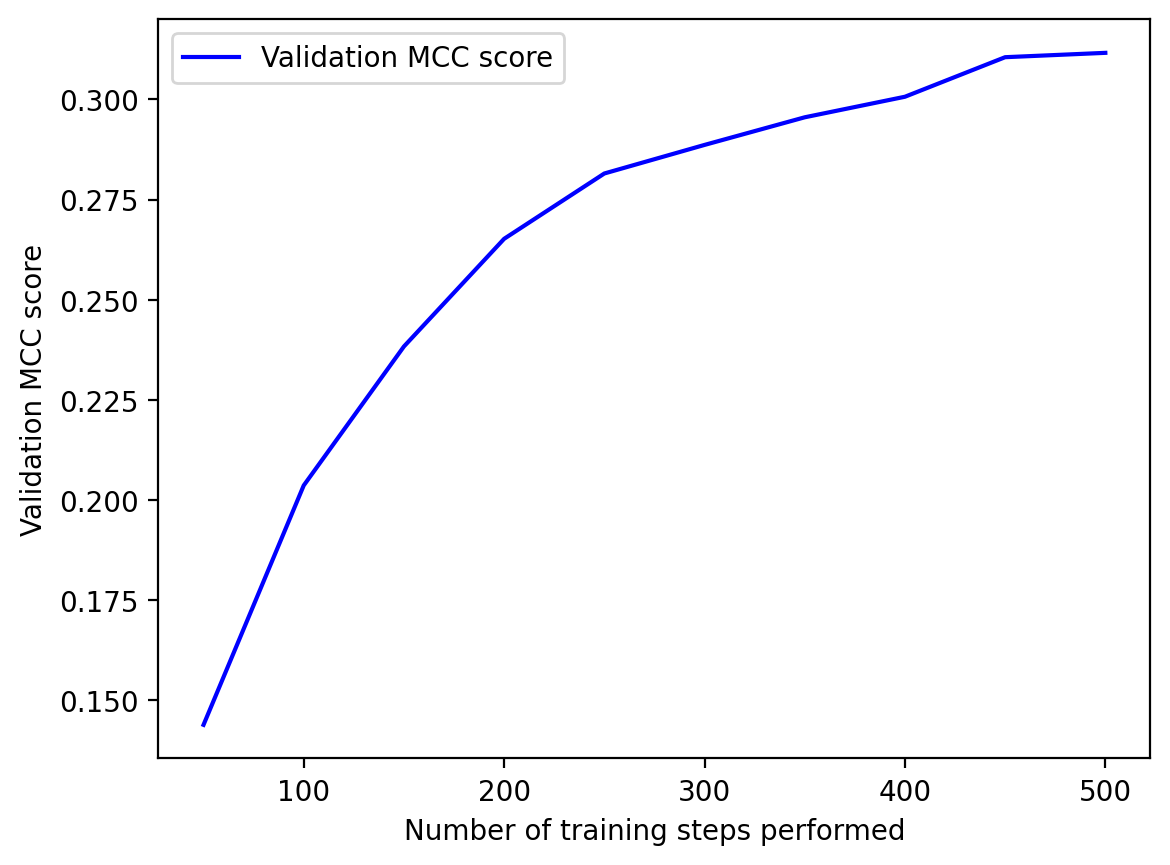

In [76]:
plt.plot(steps, eval_f1_score, 'b', label='Validation MCC score')
plt.xlabel('Number of training steps performed')
plt.ylabel('Validation MCC score')
plt.legend()
plt.show()

## Interpretability: analysis of attention weights

The following part performs a detailed analysis of attention weights from a transformer model applied to genomic sequences.
The `get_final_layer_attention` function tokenizes an input sequence, processes it through the model to extract final layer attention weights, and returns these weights along with token IDs.
The `compute_token_attention` function calculates average attention scores for each token across multiple sequences, identifies the top k tokens, and aggregates their scores.
The `plot_token_attention_histogram` function visualizes these top tokens and their average attention scores in a histogram.
Finally, the `analyze_sequences_for_histogram` function processes a list of sequences, extracts attention weights, computes token lists, and returns these for further analysis, ensuring reproducibility by setting random seeds and limiting the sample size if necessary.

In [154]:
import torch
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

def get_final_layer_attention(model, tokenizer, sequence):
    """
    Tokenizes the input sequence, processes it through the model to extract final layer
    attention weights, and returns these weights along with input token IDs.

    Args:
        model: The transformer model to process the input sequence.
        tokenizer: The tokenizer to convert the input sequence to tokens.
        sequence: The input sequence to be tokenized and processed.

    Returns:
        final_layer_attention (numpy.ndarray): The attention weights from the final layer.
        input_ids (tensor): The token IDs of the input sequence.
    """
    # Tokenize the input sequence and convert to tensors
    inputs = tokenizer(sequence, return_tensors="pt", truncation=True, max_length=200)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Disable gradient calculation for inference
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Extract attention from the final layer, keep all heads
    final_layer_attention = outputs.attentions[-1].squeeze(0)  # Shape: (num_heads, seq_len, seq_len)
    return final_layer_attention.cpu().numpy(), inputs['input_ids'][0]

def compute_token_attention(attention_weights_list, token_lists, k=5):
    """
    Calculates the average attention score for each token across multiple sequences,
    identifies the top k tokens, and aggregates their scores.

    Args:
        attention_weights_list (list): A list of attention weights from multiple sequences.
        token_lists (list): A list of token IDs corresponding to the sequences.
        k (int): The number of top tokens to identify.

    Returns:
        avg_token_attention (dict): A dictionary of tokens and their average attention scores.
    """
    token_attention_dict = defaultdict(list)

    # Compute average attention for each token and identify top k tokens
    for attn, tokens in zip(attention_weights_list, token_lists):
        avg_attn = attn.mean(axis=0)  # Average across heads
        top_k_indices = np.argsort(avg_attn.sum(axis=0))[-k:]  # Top k attended-to tokens

        for idx in top_k_indices:
            token = tokens[idx]
            score = avg_attn[:, idx].mean()  # Average attention to this token
            token_attention_dict[token].append(score)

    # Calculate average attention for each token
    avg_token_attention = {token: np.mean(scores) for token, scores in token_attention_dict.items()}
    return avg_token_attention

def plot_token_attention_histogram(token_attention_dict, top_k=20):
    """
    Generates a histogram plot of the top k tokens by their average attention scores.

    Args:
        token_attention_dict (dict): A dictionary of tokens and their attention scores.
        top_k (int): The number of top tokens to display in the histogram.
    """
    # Sort tokens by their average attention scores in descending order
    sorted_tokens = sorted(token_attention_dict.items(), key=lambda item: item[1], reverse=True)
    top_tokens, top_attention_scores = zip(*sorted_tokens[:top_k])

    # Plot the top k tokens and their average attention scores
    plt.figure(figsize=(12, 6))
    plt.bar(range(top_k), top_attention_scores, align='center')
    plt.xticks(range(top_k), top_tokens, rotation=90)
    plt.xlabel('Tokens')
    plt.ylabel('Average Attention Score')
    plt.title('Top Tokens by Attention Score')
    plt.tight_layout()
    plt.show()

def analyze_sequences_for_histogram(model, tokenizer, sequences, n_samples=2000):
    """
    Processes a list of sequences to extract attention weights and compute token lists.
    Limits the number of sequences to n_samples if necessary.

    Args:
        model: The transformer model to process the input sequences.
        tokenizer: The tokenizer to convert the input sequences to tokens.
        sequences (list): A list of input sequences to be processed.
        n_samples (int): The maximum number of sequences to process.

    Returns:
        attention_weights_list (list): A list of attention weights from multiple sequences.
        token_lists (list): A list of token IDs corresponding to the sequences.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(11)

    # Limit the number of sequences to n_samples if necessary
    if len(sequences) > n_samples:
        sequences = np.random.choice(sequences, n_samples, replace=False)

    attention_weights_list = []
    token_lists = []

    # Process each sequence to extract attention weights and tokens
    for seq in tqdm(sequences):
        attn, input_ids = get_final_layer_attention(model, tokenizer, seq)
        tokens = tokenizer.convert_ids_to_tokens(input_ids)

        attention_weights_list.append(attn)
        token_lists.append(tokens)

    return attention_weights_list, token_lists


In [156]:
# Concatenate training and validation data along the rows
data = pd.concat([train_data, val_data], axis=0)

# Define column names for the top token names and their corresponding scores
token_name_columns = ['top_token_name_' + str(int(i)) for i in range(1, 11)]
token_score_columns = ['top_token_score_' + str(int(i)) for i in range(1, 11)]

# Define index labels for components
index = ['component_' + str(int(i)) for i in range(1, 17)]

# Map the component indices to their respective labels
label_mapping = {
    'component_1': 'Tissue invariant',
    'component_2': 'Stromal A',
    'component_3': 'Embryonic / primitive',
    'component_4': 'Stromal B',
    'component_5': 'Lymphoid',
    'component_6': 'Renal / cancer',
    'component_7': 'Placental',
    'component_8': 'Neural',
    'component_9': 'Cardiac',
    'component_10': 'Organ devel. / renal',
    'component_11': 'Pulmonary devel.',
    'component_12': 'Musculoskeletal',
    'component_13': 'Digestive',
    'component_14': 'Vascular / endothelial',
    'component_15': 'Myeloid / erythroid',
    'component_16': 'Cancer / epithelial'
}

# Create a DataFrame with specified columns and indices
df = pd.DataFrame(columns=token_name_columns + token_score_columns, index=index)

# Map the DataFrame indices to the descriptive component labels
df.index = df.index.map(lambda x: label_mapping[x])

In [158]:
# Set the random seed for reproducibility
np.random.seed(42)

# Iterate through each component and its corresponding index in the DataFrame
for component, index in zip(range(1, 17), df.index):
    # Select sequences corresponding to the current component
    selected_sequence = list(data.loc[data['component'] == component, 'raw_sequence'])

    # Analyze the sequences to get attention weights and token lists
    attention_weights_list, token_lists = analyze_sequences_for_histogram(model, tokenizer, selected_sequence, n_samples=1000)

    # Compute the average attention scores for the tokens
    token_attention_dict = compute_token_attention(attention_weights_list, token_lists, k=10)

    # Sort the tokens by their average attention scores in descending order
    sorted_tokens = sorted(token_attention_dict.items(), key=lambda item: item[1], reverse=True)

    # Extract the top 10 tokens and their corresponding attention scores
    top_tokens, top_attention_scores = zip(*sorted_tokens[:10])

    # Update the DataFrame with the top tokens and their scores for the current component
    df.loc[index, token_name_columns] = top_tokens
    df.loc[index, token_score_columns] = top_attention_scores


100%|██████████| 1000/1000 [00:14<00:00, 68.32it/s]


In [90]:
# df.to_csv('df_component_token_attention_1000.csv')

### Heatmap of token attention scores

The following plot is a heatmap of attention scores to various tokens across various DHSs components. For each class label, the top 10 tokens in terms of model's attention have been chosen, and sorted by magnitude. These top 10 tokens have been the most important tokens in all sequences that were correctly classified by the model as the ones that belong to their corresponding labels.

A sharper distribution in each category indicates more exclusive attention to certain tokens, whereas a flatter distribution means that the attention was relatively divided among various tokens.

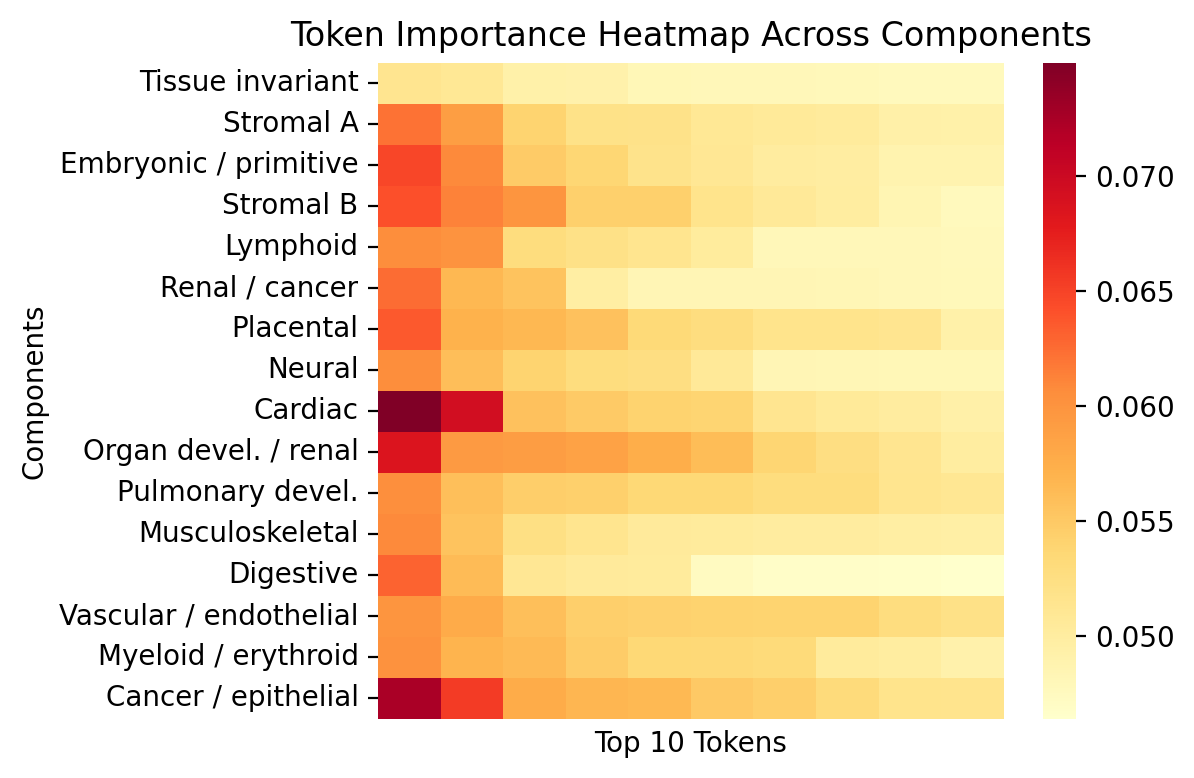

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the inline backend for the figure format to 'retina' for high-resolution plots
%config InlineBackend.figure_format = 'retina'

# Convert numerical values in the DataFrame to floats and ensure other values remain as strings
df = df.map(lambda x: float(x) if isinstance(x, (int, float)) else str(x)).copy()

# Separate the DataFrame into token names and token scores
token_names = df.iloc[:, :10]
token_scores = df.iloc[:, 10:]

# Ensure token scores are numeric, coercing any errors
token_scores = token_scores.apply(pd.to_numeric, errors='coerce')

# Create a new figure for the heatmap with specified size
plt.figure(figsize=(6, 4))

# Plot a heatmap of the token scores
sns.heatmap(token_scores, annot=False, cmap="YlOrRd", xticklabels=False)

# Add title and labels to the heatmap
plt.title("Token Importance Heatmap Across Components")
plt.xlabel("Top 10 Tokens")
plt.ylabel("Components")

# Adjust the layout to fit everything neatly
plt.tight_layout()

# Save the heatmap to a file
plt.savefig('./figs/heatmap_attention.png')

# Display the heatmap
plt.show()

### Word cloud of token attention scores

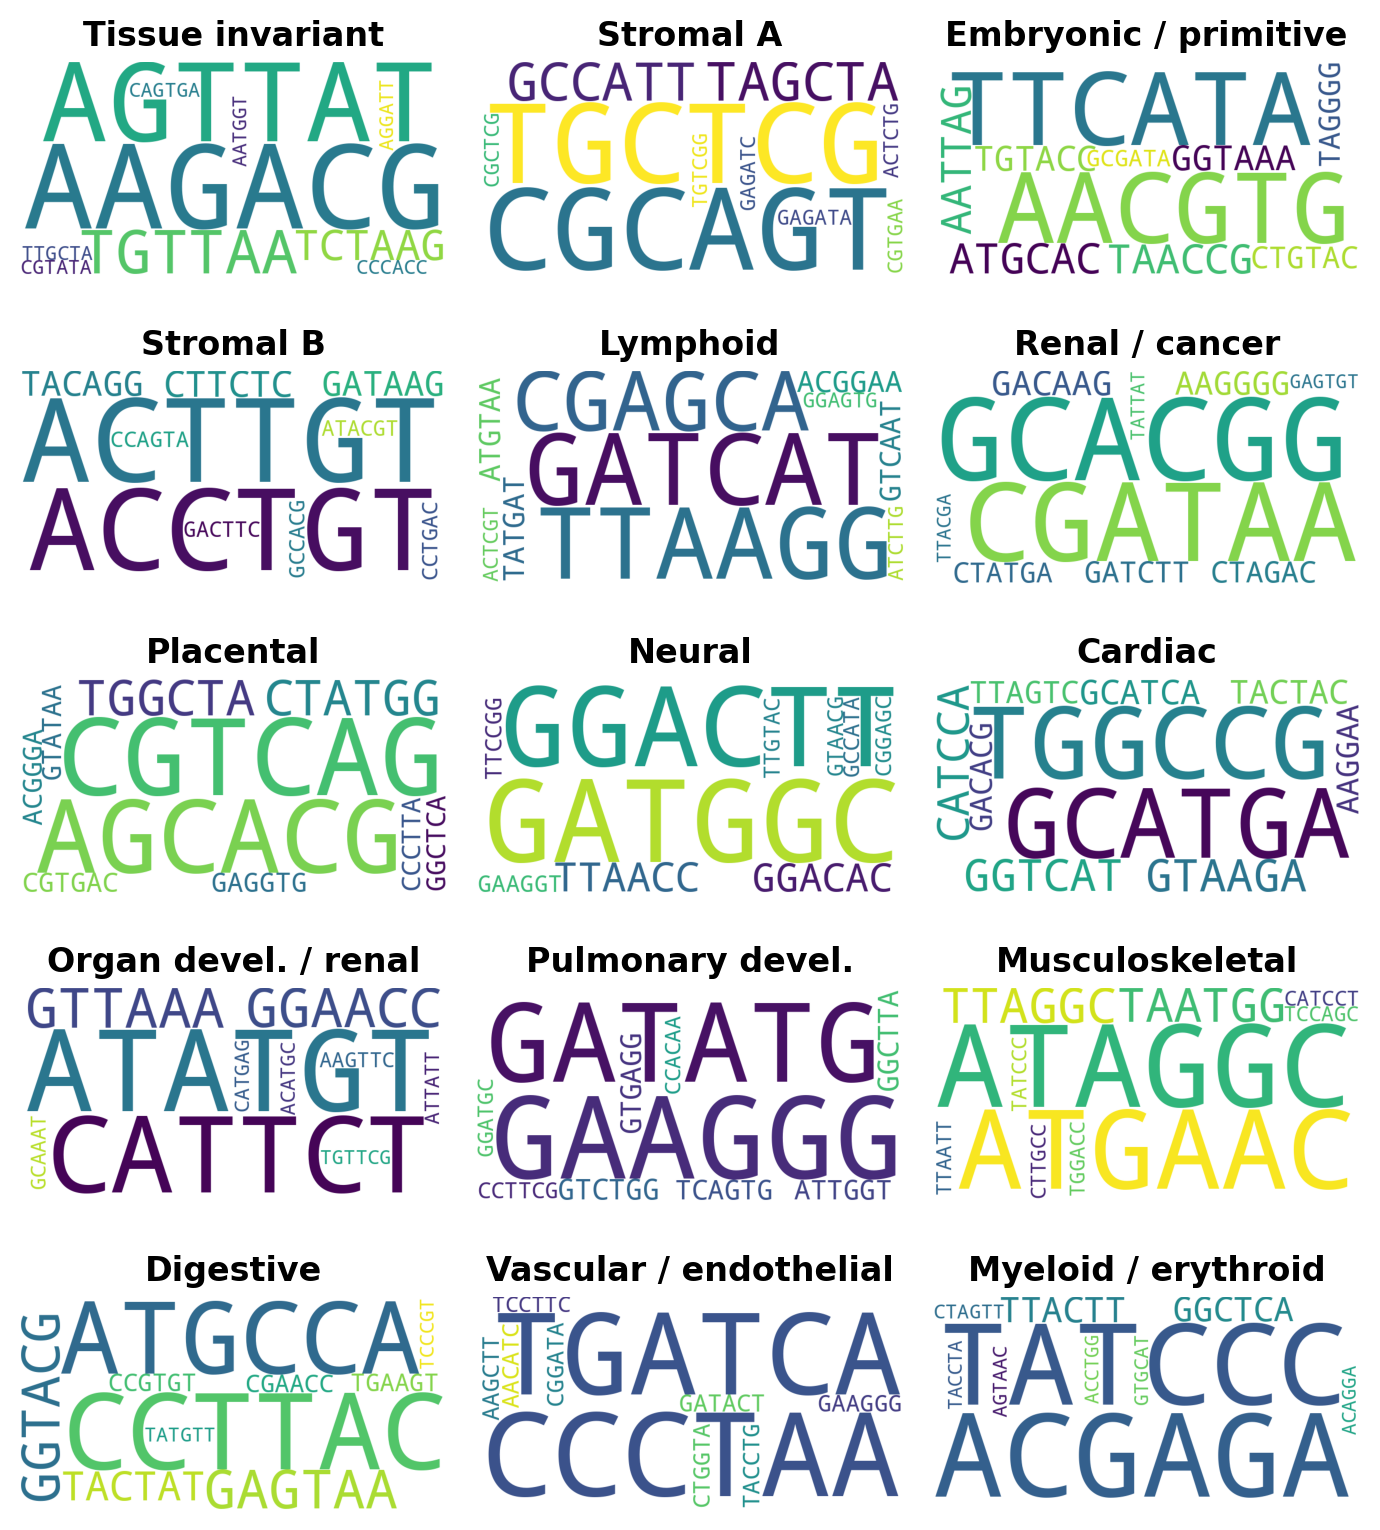

In [160]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

def create_wordcloud(component_row, n=16):
    """
    Generates a word cloud from the top n tokens and their scores for a given component.

    Args:
        component_row (Series): A row from the DataFrame representing a component.
        n (int): The number of top tokens to include in the word cloud.

    Returns:
        wordcloud (WordCloud): The generated word cloud.
    """
    # Convert token scores to numeric values, handling any errors
    scores = pd.to_numeric(component_row[10:], errors='coerce')
    tokens = component_row[:10]

    # Filter out the <cls> token and its corresponding score
    filtered_tokens = [token for token in tokens if token != "<cls>"]
    filtered_scores = [score for token, score in zip(tokens, scores) if token != "<cls>"]

    # Create a dictionary of tokens and their scores
    token_dict = dict(zip(filtered_tokens, filtered_scores))

    # Get the top n tokens with the highest scores, ignoring NaN values
    top_n = {k: v for k, v in sorted(token_dict.items(), key=lambda x: x[1], reverse=True)[:n] if pd.notnull(v)}

    # Generate a word cloud from the token frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_n)
    return wordcloud

# Assuming df is your DataFrame
# Create subplots for the word clouds
fig, axs = plt.subplots(5, 3, figsize=(7, 8))

# Generate and plot a word cloud for each component
for i, ax in enumerate(axs.flatten()):
    wordcloud = create_wordcloud(df.iloc[i])
    ax.imshow(wordcloud)  # Display the word cloud
    ax.axis('off')  # Hide the axes
    ax.set_title(list(df.index)[i], fontweight='bold')  # Set the title as the component label

# Adjust the layout to fit everything neatly
plt.tight_layout()

# Save the word cloud figure to a file
plt.savefig('./figs/word_cloud.png')

# Display the word clouds
plt.show()

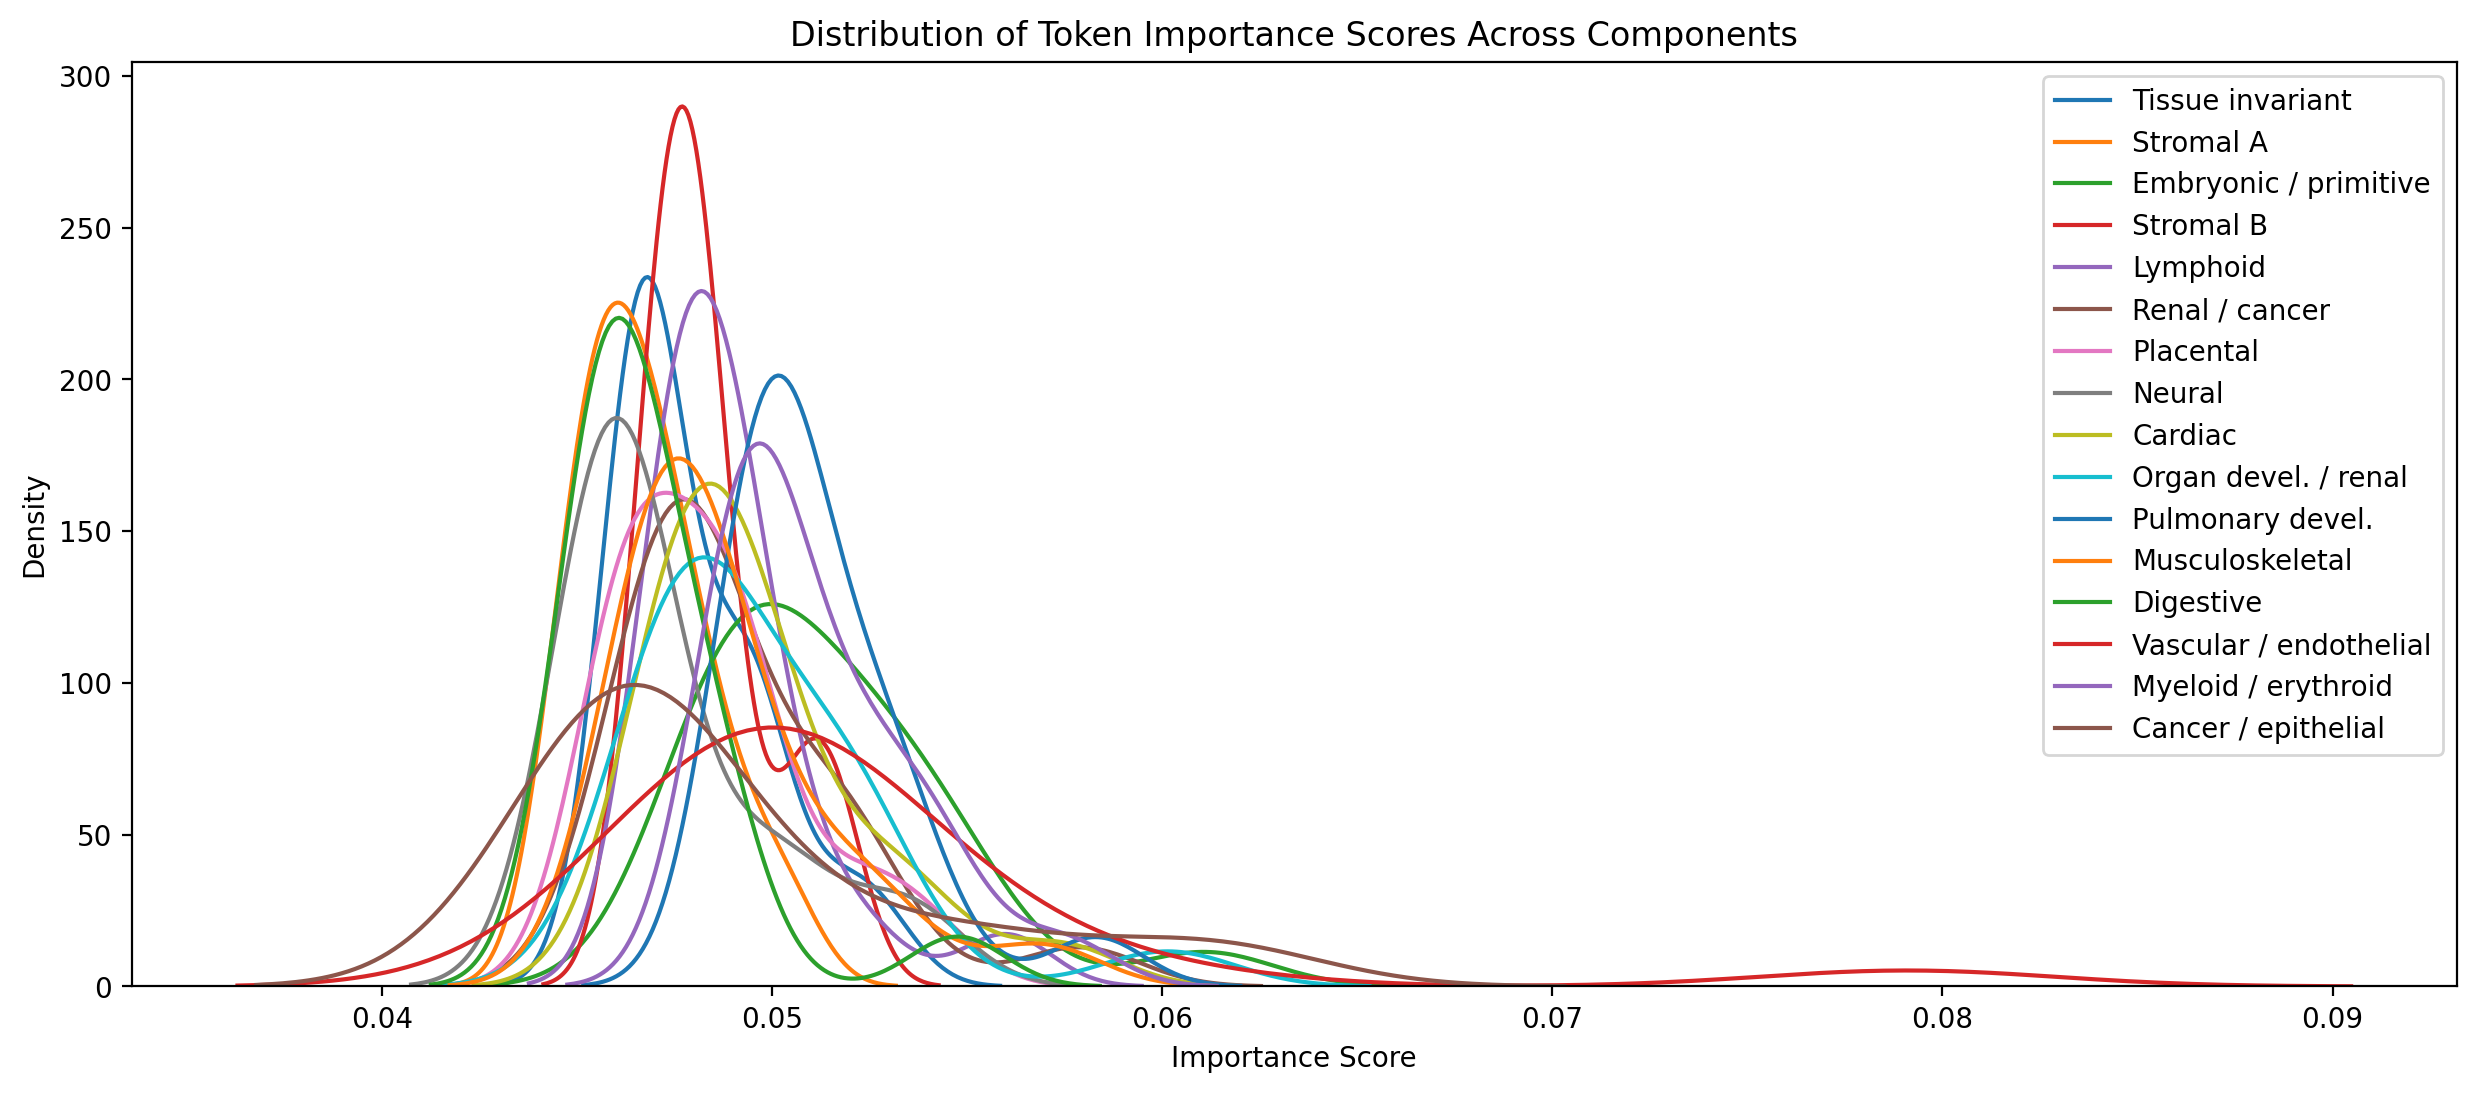

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


plt.figure(figsize=(15, 6))
for i in range(len(df)):
    token_scores = pd.to_numeric(df.iloc[i, 20:], errors='coerce').dropna()
    sns.kdeplot(token_scores, label=df.index[i])

plt.title("Distribution of Token Importance Scores Across Components")
plt.xlabel("Importance Score")
plt.ylabel("Density")
plt.legend()
plt.show()